# Financial Sentiment Analysis

[Dataset source](https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis)

In [1]:
!rm -f tracing_database.json
%pip install --upgrade great-ai > /dev/null

You should consider upgrading via the '/Users/andras/great-ai-interview-task/.env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd

data = pd.read_csv('data/data.csv')

pd.set_option("display.max_rows", 30)
pd.set_option("display.max_columns", 30)
data.head(30)

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
5,$SPY wouldn't be surprised to see a green close,positive
6,Shell's $70 Billion BG Deal Meets Shareholder ...,negative
7,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,negative
8,Kone 's net sales rose by some 14 % year-on-ye...,positive
9,The Stockmann department store will have a tot...,neutral


In [3]:
from great_ai import add_ground_truth, delete_ground_truth

X = data['Sentence'].to_list()
y = data['Sentiment'].to_list()

add_ground_truth(X, y, train_split_ratio=0.85, test_split_ratio=0.15)

Environment variable ENVIRONMENT is not set, defaulting to development mode ‼️
Cannot find credentials files, defaulting to using ParallelTinyDbDriver
The selected tracing database (ParallelTinyDbDriver) is not recommended for production
Cannot find credentials files, defaulting to using LargeFileLocal
GreatAI (v0.1.10): configured ✅
  🔩 tracing_database: ParallelTinyDbDriver
  🔩 large_file_implementation: LargeFileLocal
  🔩 is_production: False
  🔩 should_log_exception_stack: True
  🔩 prediction_cache_size: 512
  🔩 dashboard_table_size: 50
You still need to check whether you follow all best practices before trusting your deployment.
> Find out more at https://se-ml.github.io/practices


In [4]:
from great_ai import query_ground_truth

train_split = query_ground_truth('train')
test_split = query_ground_truth('test')

In [5]:
from great_ai.utilities import clean, simple_parallel_map
import re
from great_ai import Trace

def normalize(text: str) -> str:
    cleaned = clean(text, convert_to_ascii=True).lower()
    return re.sub(r"[^a-z]+", " ", cleaned)

X_train = simple_parallel_map(normalize, [t.input for t in train_split])
X_test = simple_parallel_map(normalize, [t.input for t in test_split])

y_train = [t.output for t in train_split]
y_test = [t.output for t in test_split]

100%|██████████| 877/877 [00:01<00:00, 718.68it/s]


In [6]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer


def create_pipeline() -> Pipeline:
    return make_pipeline(
        TfidfVectorizer(min_df=5, max_df=0.3, ngram_range=(1, 3), sublinear_tf=True),
        SGDClassifier(max_iter=10000, tol=1e-4, penalty="elasticnet")
    )

In [7]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats

optimisation_pipeline = RandomizedSearchCV(
    create_pipeline(),
    {
        "sgdclassifier__alpha": scipy.stats.uniform(0.00005, 0.01),
        "sgdclassifier__l1_ratio": scipy.stats.uniform(0.5, 0.4),
    },
    cv=4,
    n_iter=150,
    verbose=1,
    scoring='f1_macro',
    n_jobs=-1
)

optimisation_pipeline.fit(X_train, y_train)
results = pd.DataFrame(optimisation_pipeline.cv_results_)
results.sort_values("rank_test_score").head(20)

Fitting 4 folds for each of 150 candidates, totalling 600 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_sgdclassifier__alpha,param_sgdclassifier__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
141,0.557538,0.036277,0.079557,0.001859,0.000139,0.74698,{'sgdclassifier__alpha': 0.0001386590973076251...,0.602778,0.583447,0.609218,0.617713,0.603289,0.012621,1
62,0.517736,0.017173,0.075006,0.008921,0.000123,0.633796,{'sgdclassifier__alpha': 0.0001230949372392475...,0.603052,0.592701,0.595310,0.615232,0.601574,0.008756,2
44,0.586568,0.034125,0.075711,0.015189,0.000101,0.744511,{'sgdclassifier__alpha': 0.0001008328469921404...,0.605709,0.586259,0.592400,0.614393,0.599690,0.011022,3
15,0.503485,0.052601,0.076652,0.005708,0.000101,0.717281,{'sgdclassifier__alpha': 0.0001012954906445695...,0.596920,0.590612,0.589020,0.608695,0.596312,0.007736,4
120,0.626889,0.037078,0.087496,0.013705,0.000104,0.521099,{'sgdclassifier__alpha': 0.0001043130639528788...,0.592821,0.585763,0.582623,0.613523,0.593683,0.012036,5
77,0.657004,0.020389,0.086646,0.021849,0.000072,0.869767,"{'sgdclassifier__alpha': 7.2395771533531e-05, ...",0.585078,0.587727,0.582360,0.600486,0.588913,0.006946,6
124,0.458076,0.003328,0.081067,0.003202,0.000286,0.729062,{'sgdclassifier__alpha': 0.0002860219318437106...,0.599120,0.565035,0.583109,0.604000,0.587816,0.015255,7
4,0.423889,0.014550,0.070364,0.010887,0.00034,0.793499,{'sgdclassifier__alpha': 0.0003401382442436040...,0.574158,0.551240,0.580991,0.593687,0.575019,0.015414,8
113,0.428109,0.023082,0.083129,0.010922,0.00044,0.682686,{'sgdclassifier__alpha': 0.0004397417391475943...,0.560192,0.534955,0.567035,0.556430,0.554653,0.011991,9
51,0.376192,0.008471,0.073243,0.005655,0.000497,0.624651,{'sgdclassifier__alpha': 0.0004970440243574691...,0.556448,0.525659,0.557745,0.535856,0.543927,0.013662,10


In [8]:
model = create_pipeline()
model.set_params(
    **optimisation_pipeline.best_params_,
    sgdclassifier__max_iter=100000,
    sgdclassifier__tol=1e-5,
)

model.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.3, min_df=5, ngram_range=(1, 3),
                                 sublinear_tf=True)),
                ('sgdclassifier',
                 SGDClassifier(alpha=0.0001386590973076251,
                               l1_ratio=0.7469804305005836, max_iter=100000,
                               penalty='elasticnet', tol=1e-05))])

              precision    recall  f1-score   support

    negative       0.41      0.17      0.24       132
     neutral       0.73      0.88      0.79       465
    positive       0.79      0.74      0.76       280

    accuracy                           0.73       877
   macro avg       0.64      0.60      0.60       877
weighted avg       0.70      0.73      0.70       877



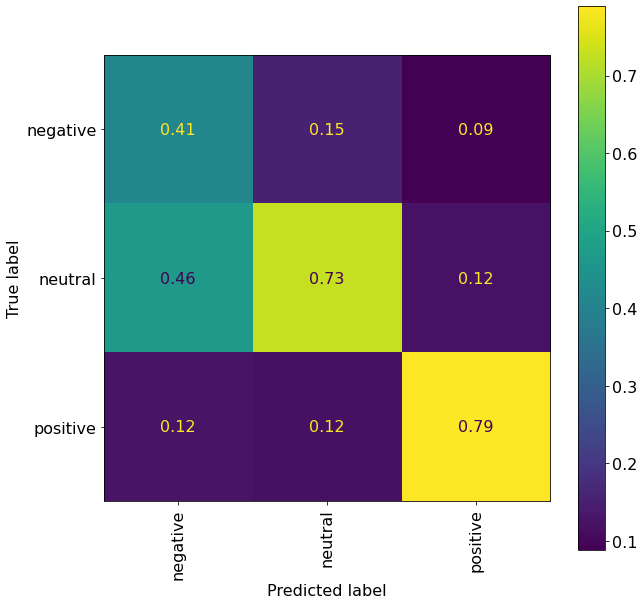

In [9]:
import matplotlib.pyplot as plt
from sklearn import metrics

%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 10)
plt.rcParams["font.size"] = 16

y_predicted = model.predict(X_test)

print(metrics.classification_report(y_test, y_predicted))
metrics.ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=y_predicted,
    xticks_rotation="vertical",
    normalize="pred",
    values_format=".2f",
)
None

In [10]:
features = model.named_steps["tfidfvectorizer"].get_feature_names_out()

for i, name in enumerate(model.named_steps["sgdclassifier"].classes_):
    weight = model.named_steps["sgdclassifier"].coef_[i]

    print(f'There are {len([w for w in weight if w != 0])} features for the`{name}` class.')

    for w, f in sorted(zip(weight, features), reverse=True)[:15]:
        if w == 0:
            break
        print(f"  {f}: {w:.4f}")

    print()

There are 501 features for the`negative` class.
  short: 4.8667
  lower: 4.4908
  fall: 4.3363
  down: 4.2191
  iwm: 4.1660
  bhp: 3.1163
  drop: 3.1113
  bearish: 3.0749
  fears: 2.8873
  falls: 2.8422
  sbux: 2.7157
  rivals: 2.2257
  puts: 2.1955
  recalls: 2.1673
  downgraded: 2.1668

There are 1501 features for the`neutral` class.
  is: 2.9445
  electricity: 2.9423
  includes: 2.9332
  to the: 2.3651
  will: 2.2602
  eps in: 2.2093
  to remain: 1.9904
  sole: 1.9867
  information: 1.9632
  while: 1.9388
  approximately: 1.8945
  share capital: 1.8895
  buy the: 1.8574
  were: 1.8406
  marketing: 1.8366

There are 1495 features for the`positive` class.
  increased: 6.4743
  increase: 6.2415
  positive: 6.2387
  won: 6.0361
  signed: 6.0156
  grew: 5.7388
  up from: 5.2212
  rise: 4.9845
  awarded: 4.5971
  double: 4.3849
  higher: 4.3683
  buy: 4.3043
  improved: 4.2427
  breakout: 4.2076
  good: 4.1502



In [11]:
def predict(text: str):
    text = normalize(text)
    features = model.named_steps["tfidfvectorizer"].transform([text])
    prediction = model.named_steps["sgdclassifier"].predict(features)[0]

    explanation = [
        (feature_name, weight)
        for weight, feature_name in sorted(
            (
                (feature_weight * feature, feature_name)
                for feature_name, feature_weight, feature in zip(
                    model.named_steps["tfidfvectorizer"].get_feature_names_out(),
                    model.named_steps["sgdclassifier"].coef_[list(model.named_steps["sgdclassifier"].classes_).index(prediction)],
                    features.toarray()[0],
                )
                if feature * feature_weight != 0
            ),
            reverse=True,
        )
    ][:10]

    return prediction, explanation

predict('''
    The last 12 months for Tesla shares have been fairly but positively volatile. 
    The stock is up in the past year, as it was trading at just under $700 per share back in early August 2021. 
    The share price spent much of late 2021 and early 2022 over the $1,000 mark. 
    Prices dipped below $1,000—and stayed there—starting in late April.

    I have been bearish on Tesla lately, owing to its elevated share price and its growing competition in the electric vehicle field.
    The competition part isn't changing much. 
    That's really only gotten worse thanks to most of the major automakers looking to get in on the market.

    However, Tesla's move to make its shares more reasonably priced should catch some attention. Thus, I'm moving to neutral on Tesla stock.
''')

('negative',
 [('bearish', 0.3701555869078035),
  ('share price', 0.13607210434349515),
  ('tesla', 0.10278360011073003),
  ('get', 0.06469031891901218),
  ('back', 0.060203369146000676),
  ('below', 0.05252493885654123),
  ('moving', 0.033521891021244074),
  ('price', 0.02861155787080013),
  ('only', 0.021472501474463123),
  ('there', 0.012862225410731364)])

In [12]:
from great_ai import save_model

save_model(model, 'financial-sentiment')

Fetching cached versions of financial-sentiment
Copying file for financial-sentiment-1
Compressing financial-sentiment-1
Model financial-sentiment uploaded with version 1


'financial-sentiment:1'